In [5]:
import numpy as np
import librosa
import joblib  # For saving models to download
from datasets import load_dataset, Audio
# from sklearnex import patch_sklearn
# patch_sklearn()
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [1]:
from datasets import load_from_disk
offline_dataset = load_from_disk("./my_offline_ds")

c:\Users\Mostafa\Downloads\Leopard detection project\Code\GMM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pathlib
# ADJUST THIS PATH to point to your specific bin folder containing the .dll files
ffmpeg_bin_path = pathlib.Path(r"C:\program files\ffmpeg\bin")

if ffmpeg_bin_path.exists():
    # This explicitly adds the folder to the DLL search path for the current process
    os.add_dll_directory(str(ffmpeg_bin_path))
    
    # Optional: Update PATH for subprocess calls (like cmd commands)
    os.environ["PATH"] = str(ffmpeg_bin_path) + os.pathsep + os.environ["PATH"]
else:
    print(f"Warning: FFmpeg bin directory not found at {ffmpeg_bin_path}")

In [35]:
# --- 1. PREPROCESSING (Loop Padding Fix) ---
def enforce_window_size(audio, target_len):
    curr_len = len(audio)
    if curr_len == target_len:
        return [audio]
    elif curr_len > target_len:
        # Cut into chunks
        chunks = []
        num_chunks = curr_len // target_len
        for i in range(num_chunks):
            start = i * target_len
            chunks.append(audio[start : start + target_len])
        return chunks
    else:
        # LOOP PADDING (The Fix)
        print("padding")
        repeats = int(np.ceil(target_len / curr_len))
        tiled = np.tile(audio, repeats)
        padded = tiled[:target_len]
        # Tiny noise to prevent perfect duplicate artifacts
        padded = padded + np.random.normal(0, 0.001, len(padded)) 
        return [padded]

In [63]:
import io
SAMPLE_RATE = 16000
WINDOW_SAMPLES = 16000 # 1.0 second
max_samples= 5e4

In [64]:
# --- 1. ADVANCED AUGMENTATION ENGINE ---
import random
def augment_audio(y, sr=16000):
    """
    Applies a random chain of augmentations to a single audio clip.
    """
    # 1. TIME STRETCH (Speed up or Slow down) - 40% chance
    # Note: This changes length, so we must fix length afterwards
    if random.random() < 0.4:
        rate = np.random.uniform(0.8, 1.2) # 0.8x to 1.2x speed
        y = librosa.effects.time_stretch(y, rate=rate)

    # 2. PITCH SHIFT (Tone change) - 40% chance
    # Shift by -2 to +2 semitones
    if random.random() < 0.4:
        steps = np.random.uniform(-2, 2)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

    # --- FIX LENGTH (Crucial after stretch) ---
    # Resizing back to WINDOW_SAMPLES before other effects
    if len(y) > WINDOW_SAMPLES:
        y = y[:WINDOW_SAMPLES]
    else:
        y = np.pad(y, (0, WINDOW_SAMPLES - len(y)), mode='constant')

    # 3. NOISE INJECTION (Static/Hiss) - 50% chance
    if random.random() < 0.5:
        noise_amp = 0.005 * np.random.uniform(0.5, 2.0)
        noise = np.random.normal(0, noise_amp, len(y))
        y = y + noise

    # 4. TIME ROLL (Shift start position) - 50% chance
    if random.random() < 0.5:
        shift = np.random.randint(0, len(y))
        y = np.roll(y, shift)

    # 5. GAIN (Volume change) - Always apply random gain
    gain = np.random.uniform(0.5, 2.0)
    y = y * gain

    return y

In [65]:
ds=offline_dataset
ds = ds.cast_column("audio", Audio(decode=False))
    
data = []
labels = []
counts = {0: 0, 1: 0}

for i, item in enumerate(ds):
    if counts[0] >= max_samples and counts[1] >= max_samples:
        break
        
    label = item['label']
    if counts[label] >= max_samples: continue

    try:
        # Now item['audio'] is guaranteed to be a dict with 'bytes'
        audio_bytes = item['audio']['bytes']
        
        # Manual Decode with Librosa
        audio, _ = librosa.load(io.BytesIO(audio_bytes), sr=SAMPLE_RATE)
        audio = librosa.util.normalize(audio)
        
        # Pad/Cut
        # if(len(audio)< WINDOW_SAMPLES):
        #     continue
        chunks = enforce_window_size(audio, WINDOW_SAMPLES)
        
        for chunk in chunks:
            mfcc = librosa.feature.mfcc(y=chunk, sr=SAMPLE_RATE, n_mfcc=13)
            # removing loudness
            mfcc_shape_only = mfcc[1:] 
                    
            mfcc_vec = np.mean(mfcc_shape_only.T, axis=0) # Now size (12,)
            
            data.append(mfcc_vec)
            labels.append(label)
            
            counts[label] += 1
            if counts[label] >= max_samples: break
            
        if i % 100 == 0:
            print(f"Collected: Class 0={counts[0]} | Class 1={counts[1]}", end='\r')

    except Exception as e:
        print(f"Error: {e}") 
        continue
        
print(f"\nFinal Counts: Class 0={counts[0]}, Class 1={counts[1]}")


padding
paddinged: Class 0=1 | Class 1=0
paddinged: Class 0=1870 | Class 1=0
paddinged: Class 0=2807 | Class 1=0
paddinged: Class 0=3714 | Class 1=0
paddinged: Class 0=5666 | Class 1=0
paddinged: Class 0=6153 | Class 1=0
padding
padding
paddinged: Class 0=9563 | Class 1=0
paddinged: Class 0=11022 | Class 1=0
padding
padding
paddinged: Class 0=12482 | Class 1=0
paddinged: Class 0=16895 | Class 1=0
padding
padding
paddinged: Class 0=18138 | Class 1=0
paddinged: Class 0=19481 | Class 1=0
paddinged: Class 0=24710 | Class 1=0
padding
padding
paddinged: Class 0=27574 | Class 1=0
paddinged: Class 0=28955 | Class 1=0
padding
paddinged: Class 0=39874 | Class 1=0
paddinged: Class 0=42438 | Class 1=0
padding
padding
paddinged: Class 0=43706 | Class 1=0
paddinged: Class 0=48727 | Class 1=0
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
padding
pad

In [66]:
import soundfile as sf
audio, _ = librosa.load(io.BytesIO(audio_bytes), sr=SAMPLE_RATE)
sf.write("training.wav",audio,SAMPLE_RATE)

In [67]:
X= np.array(data)
y= np.array(labels)

In [68]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (80000, 12)
X_test shape: (20000, 12)
y_train shape: (80000,)
y_test shape: (20000,)


In [69]:
# 2. Train Scaler (Crucial for realtime)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
print("Training GMMs...")
gmm0 = GaussianMixture(n_components=16, covariance_type='diag', random_state=42)
gmm0.fit(X_train_scaled[y_train == 0])
gmm1 = GaussianMixture(n_components=16, covariance_type='diag', random_state=42)
gmm1.fit(X_train_scaled[y_train == 1])

Training GMMs...


,n_components,16
,covariance_type,'diag'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


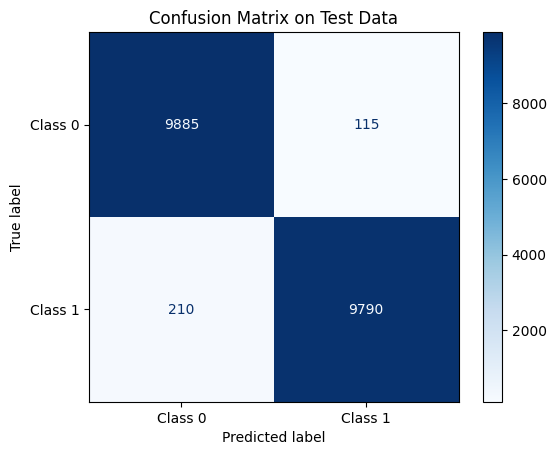

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define a prediction function using the trained GMMs
def predict_gmm(X_scaled, gmm0, gmm1):
    score0 = gmm0.score_samples(X_scaled)
    score1 = gmm1.score_samples(X_scaled)
    # Predict class 1 if score for gmm1 is higher, else class 0
    return (score1 > score0).astype(int)

# Make predictions on the scaled test data
y_pred = predict_gmm(X_test_scaled, gmm0, gmm1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Data')
plt.show()

In [72]:
# Train Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                    class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = rf_model.predict(X_test_scaled)
print("\n--- Training Report ---")
print(classification_report(y_test, y_pred))

Training Random Forest...

--- Training Report ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10000
           1       0.99      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [73]:
# Save
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
print("✅ Models saved successfully.")

✅ Models saved successfully.
